In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import random

In [2]:
from sklearn.metrics import r2_score
from sklearn.impute import KNNImputer

In [3]:
heart = pd.read_csv('HeartData.csv')
heart.drop('Unnamed: 0',axis=1,inplace=True)

In [4]:
float_vec = np.vectorize(float)
nan_feature = []
nan_feature_dict = {}
for icol in heart.columns:
    L = np.sum(heart.loc[:,icol]=='?')
    if (L==0):
        heart.loc[:,icol] = float_vec(heart.loc[:,icol].values)
    else:
        nan_feature.append(icol)
        nan_feature_dict[icol] = L
        heart.loc[heart[icol]!='?',icol] = float_vec(heart.loc[heart[icol]!='?',icol].values)

In [5]:
d = zip(list(nan_feature_dict.keys()), list(nan_feature_dict.values()))
d = sorted(d, key = lambda x: x[1], reverse=True)
pd.DataFrame(d)

,0,1
0,ca,413
1,thal,320
2,slope,207
3,fbs,83
4,chol,23
5,oldpeak,6
6,trestbps,3
7,restecg,2
8,thalach,2
9,exang,2


In [6]:
counter = 0
for irow in range(heart.shape[0]):
    L = np.sum(heart.iloc[irow,:]=='?')
    if (L!=0):
        counter = counter+1
counter

422

In [7]:
422/720

0.5861111111111111

In [8]:
heart.to_csv('HeartData.csv')

In [9]:
feature_mean   = {}
feature_median = {}

for icol in heart.columns:
    
    if icol not in nan_feature:
        continue
    L = heart.loc[heart[icol]!='?',icol].values 
    feature_mean[icol] = np.mean(L)
    feature_median[icol] = np.median(L)
    
clean_index = []
dirty_index = []

for ind in list(heart.index):
    if (np.sum(heart.loc[ind,:]=='?')==0):
        clean_index.append(ind)
    else:
        dirty_index.append(ind)

In [10]:
picked_cleanindex = random.sample(clean_index,int((1./3.)*len(clean_index)))
picked_cleanindex = list(set(picked_cleanindex))

In [11]:
clean_heart_mean   = heart.loc[picked_cleanindex,:].copy()
clean_heart_median = heart.loc[picked_cleanindex,:].copy()

In [12]:
clean_heart_mean.loc[:,nan_feature] = np.nan
clean_heart_median.loc[:,nan_feature] = np.nan

In [13]:
for ifeature in nan_feature:
    clean_heart_mean.loc[:,ifeature]   = feature_mean[ifeature]
    clean_heart_median.loc[:,ifeature] = feature_median[ifeature]

In [14]:
def MSE(y_true,y_pred):
    return (np.sum((y_true-y_pred)**2))/(y_true.shape[0]**2)

In [15]:
MSE_mean   = {}
MSE_median = {}

for ifeature in nan_feature:
    
    true_val        = heart.loc[picked_cleanindex,ifeature].values
    temp_mean_val   = clean_heart_mean.loc[:,ifeature].values
    temp_median_val = clean_heart_median.loc[:,ifeature].values
    
    MSE_mean[ifeature]   = MSE(true_val,temp_mean_val)
    MSE_median[ifeature] = MSE(true_val,temp_median_val)

In [16]:
#np.sum(clean_heart_knn.loc[:,ifeature]=='?')

In [17]:
#clean_heart_knn.shape

In [47]:
clean_heart_knn    = heart.copy()

for ifeature in nan_feature:
    if (np.sum(clean_heart_knn.loc[:,ifeature]=='?')!=0):
        bool_index = clean_heart_knn[ifeature]=='?'
        clean_heart_knn.loc[bool_index,ifeature] = np.nan
        
knn = KNNImputer()
knn.set_params(n_neighbors = 6)
knn_result = knn.fit_transform(clean_heart_knn)
knn_result_df = pd.DataFrame(data = knn_result, columns=heart.columns)

In [48]:
clean_heart_knn2 = heart.loc[picked_cleanindex,:].copy()
clean_heart_knn2.loc[:,nan_feature] = np.nan
data = knn.transform(clean_heart_knn2)
knn_result_df2 = pd.DataFrame(data = data, columns=heart.columns)

In [49]:
#imp_df = pd.DataFrame().from_dict(MSE_mean,orient='index')
#imp_df.columns = ['mean']
#imp_df['median'] = MSE_median.values()

In [50]:
MSE_knn = {}

for ifeature in nan_feature:
    
    true_val        = heart.loc[picked_cleanindex,ifeature].values
    temp_knn_val    = knn_result_df2.loc[:,ifeature].values
    
    MSE_knn[ifeature]   = MSE(true_val,temp_knn_val)

In [51]:
imp_df['knn_6'] = MSE_knn.values()
imp_df.head(3)

,mean,median,knn_1,knn_2,knn_3,knn_4,knn_5,knn_6
trestbps,3.661705,3.748495,0.936333,1.670212,2.209355,2.716840,2.924730,3.053929
chol,42.902409,28.044077,22.481175,36.954392,41.691811,69.550237,81.649117,78.494091
fbs,0.001236,0.001428,0.000714,0.000791,0.000862,0.000912,0.000935,0.000938


In [52]:
imp_df.reset_index(inplace=True)

In [53]:
imp_df.to_csv('imputationDF.csv')

(0.0, 80.0)

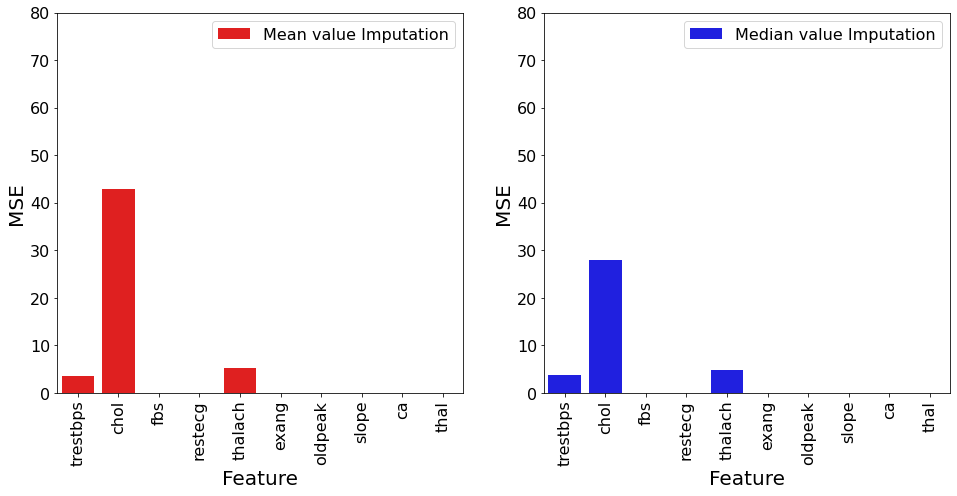

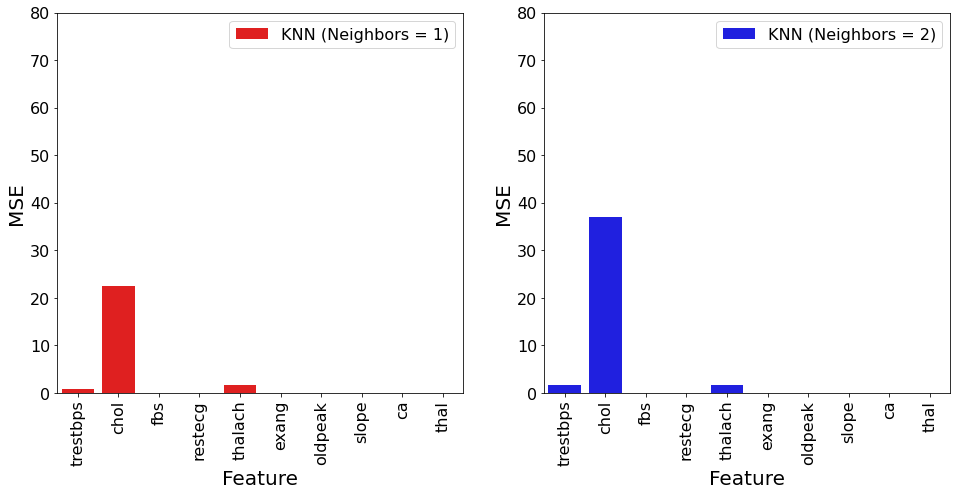

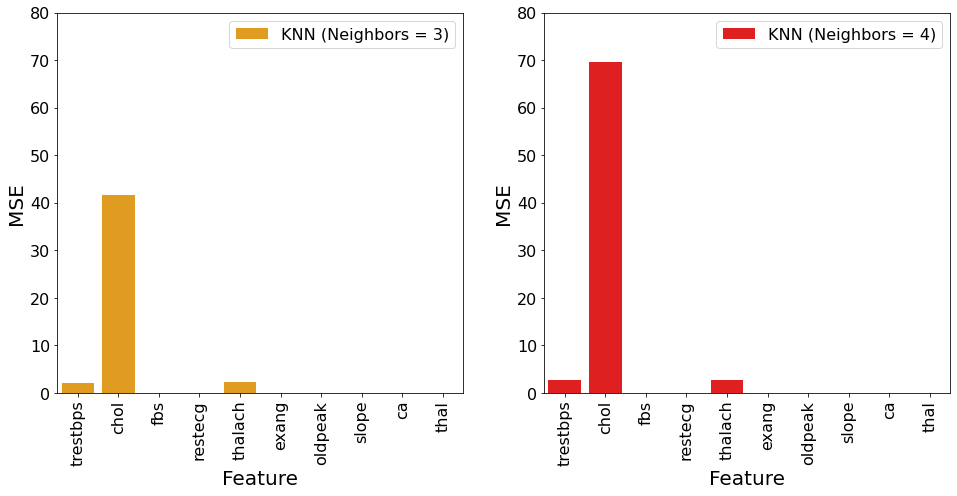

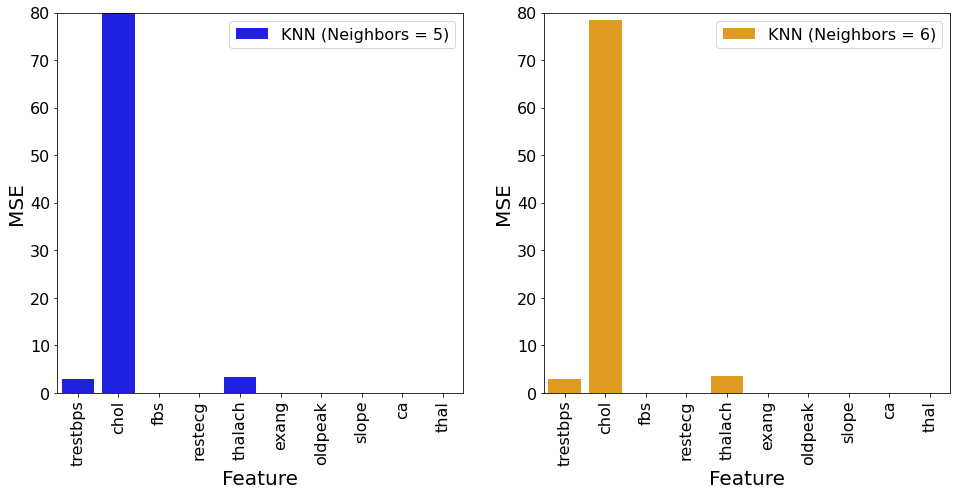

In [56]:
ig, axis = plt.subplots(1,2,figsize=(16,7))

sns.barplot(data = imp_df, x = 'index', y = 'mean', color = 'red', ax = axis[0], label = 'Mean value Imputation')
axis[0].set_xlabel('Feature', fontsize = 20)
axis[0].set_ylabel('MSE', fontsize = 20)
axis[0].set_xticklabels(axis[0].get_xticklabels(),fontsize=14, rotation = 90)
axis[0].tick_params(axis='both',labelsize=16)
axis[0].legend(fontsize = 16)
axis[0].set_ylim([0,80])

sns.barplot(data = imp_df, x = 'index', y = 'median', color = 'blue', ax = axis[1], label = 'Median value Imputation')
axis[1].set_xlabel('Feature', fontsize = 20)
axis[1].set_ylabel('MSE', fontsize = 20)
axis[1].set_xticklabels(axis[1].get_xticklabels(),fontsize=14, rotation = 90)
axis[1].tick_params(axis='both',labelsize=16)
axis[1].legend(fontsize = 16);
axis[1].set_ylim([0,80]);

fig, axis = plt.subplots(1,2,figsize=(16,7))

sns.barplot(data = imp_df, x = 'index', y = 'knn_1', color = 'red', ax = axis[0], label = 'KNN (Neighbors = 1)')
axis[0].set_xlabel('Feature', fontsize = 20)
axis[0].set_ylabel('MSE', fontsize = 20)
axis[0].set_xticklabels(axis[0].get_xticklabels(),fontsize=14, rotation = 90)
axis[0].tick_params(axis='both',labelsize=16)
axis[0].legend(fontsize = 16)

sns.barplot(data = imp_df, x = 'index', y = 'knn_2', color = 'blue', ax = axis[1], label = 'KNN (Neighbors = 2)')
axis[1].set_xlabel('Feature', fontsize = 20)
axis[1].set_ylabel('MSE', fontsize = 20)
axis[1].set_xticklabels(axis[1].get_xticklabels(),fontsize=14, rotation = 90)
axis[1].tick_params(axis='both',labelsize=16)
axis[1].legend(fontsize = 16)

axis[0].set_ylim([0,80])
axis[1].set_ylim([0,80])

fig, axis = plt.subplots(1,2,figsize=(16,7))

sns.barplot(data = imp_df, x = 'index', y = 'knn_3', color = 'orange', ax = axis[0], label = 'KNN (Neighbors = 3)')
axis[0].set_xlabel('Feature', fontsize = 20)
axis[0].set_ylabel('MSE', fontsize = 20)
axis[0].set_xticklabels(axis[0].get_xticklabels(),fontsize=14, rotation = 90)
axis[0].tick_params(axis='both',labelsize=16)
axis[0].legend(fontsize = 16);

sns.barplot(data = imp_df, x = 'index', y = 'knn_4', color = 'red', ax = axis[1], label = 'KNN (Neighbors = 4)')
axis[1].set_xlabel('Feature', fontsize = 20)
axis[1].set_ylabel('MSE', fontsize = 20)
axis[1].set_xticklabels(axis[1].get_xticklabels(),fontsize=14, rotation = 90)
axis[1].tick_params(axis='both',labelsize=16)
axis[1].legend(fontsize = 16)

axis[0].set_ylim([0,80])
axis[1].set_ylim([0,80])

fig, axis = plt.subplots(1,2,figsize=(16,7))

sns.barplot(data = imp_df, x = 'index', y = 'knn_5', color = 'blue', ax = axis[0], label = 'KNN (Neighbors = 5)')
axis[0].set_xlabel('Feature', fontsize = 20)
axis[0].set_ylabel('MSE', fontsize = 20)
axis[0].set_xticklabels(axis[0].get_xticklabels(),fontsize=14, rotation = 90)
axis[0].tick_params(axis='both',labelsize=16)
axis[0].legend(fontsize = 16)

sns.barplot(data = imp_df, x = 'index', y = 'knn_6', color = 'orange', ax = axis[1], label = 'KNN (Neighbors = 6)')
axis[1].set_xlabel('Feature', fontsize = 20)
axis[1].set_ylabel('MSE', fontsize = 20)
axis[1].set_xticklabels(axis[1].get_xticklabels(),fontsize=14, rotation = 90)
axis[1].tick_params(axis='both',labelsize=16)
axis[1].legend(fontsize = 16);

axis[0].set_ylim([0,80])
axis[1].set_ylim([0,80])

In [ ]:
fig, axis = plt.subplots(1,1,figsize=(12,8))
sns.lineplot(data = imp_df, x = 'index', y = 'mean',   color = 'red',  marker = 'o', ax = axis, label = 'Mean Imputation' )
sns.lineplot(data = imp_df, x = 'index', y = 'median', color = 'blue', marker = 'o', ax = axis, label = 'Median Imputation' )
sns.lineplot(data = imp_df, x = 'index', y = 'knn_1', color = 'green', marker = 'o', ax = axis, label = 'KNN (Neighbors = 1)')
sns.lineplot(data = imp_df, x = 'index', y = 'knn_2', color = 'cyan', marker = 'o', ax = axis, label = 'KNN (Neighbors = 2)')
sns.lineplot(data = imp_df, x = 'index', y = 'knn_3', color = 'black', marker = 'o', ax = axis, label = 'KNN (Neighbors = 3)')
sns.lineplot(data = imp_df, x = 'index', y = 'knn_4', color = 'purple', marker = 'o', ax = axis, label = 'KNN (Neighbors = 4)')
sns.lineplot(data = imp_df, x = 'index', y = 'knn_5', color = 'orange', marker = 'o', ax = axis, label = 'KNN (Neighbors = 5)')
sns.lineplot(data = imp_df, x = 'index', y = 'knn_6', color = 'brown', marker = 'o', ax = axis, label = 'KNN (Neighbors = 6)')

axis.set_xlabel('Feature', fontsize = 20)
axis.set_ylabel('MSE', fontsize = 20)
axis.tick_params(axis='x',labelsize=14, labelrotation = 90)
axis.tick_params(axis='y',labelsize=14)
axis.legend(fontsize=12)
axis.grid(axis = 'x');

JUST DO A PRIMILINARY RANDOM FOREST AND LOGISTIC REGRESSION TO FIND IMPORTANT FEATURES

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [ ]:
glm = LogisticRegression()
rfc = RandomForestClassifier()

In [ ]:
glm.get_params()

In [ ]:
#?glm

In [ ]:
#?rfc

In [ ]:
glm.set_params(solver = 'sag')

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = heart.loc[clean_index,:].drop(['num'],axis=1).copy()
Y = heart.loc[clean_index,'num']

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.33, random_state=144, shuffle=True, stratify=Y) 

In [ ]:
#fitting loggistic regression
glm.set_params(max_iter  = 1e5, C = 0.001)
glm.fit(X_train,Y_train)
r2_train = np.round(glm.score(X_train,Y_train),3)
r2_test  = np.round(glm.score(X_test,Y_test),3)
print('Trian score is :' + str(r2_train))
print('Test  score is :' + str(r2_test))

In [ ]:
rfc.set_params(max_depth = 4)
rfc.fit(X_train,Y_train)
r2_train = np.round(rfc.score(X_train,Y_train),3)
r2_test  = np.round(rfc.score(X_test,Y_test),3)
print('Trian score is :' + str(r2_train))
print('Test  score is :' + str(r2_test))

In [ ]:
from sklearn.feature_selection import SelectKBest

In [ ]:
data = sorted(zip(X.columns,rfc.feature_importances_),key = lambda x : x[1],reverse=True)
df = pd.DataFrame(data = data)
df.columns = ['feature','importance']

In [ ]:
fig, axis = plt.subplots(1,1,figsize=(12,8))
sns.barplot(data = df, x='feature', y = 'importance', color = 'red', ax = axis)
axis.set_xlabel('Feature', fontsize = 16)
axis.set_ylabel('Feature Importance (Random Forest)', fontsize = 16)
axis.set_xticklabels(axis.get_xticklabels(),rotation = 90, fontsize = 14)
plt.yticks(fontsize=14);

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
SC = StandardScaler()

In [ ]:
X_SC = SC.fit_transform(X)

In [ ]:
XSC_train, XSC_test, Y_train, Y_test = train_test_split(X_SC,Y, test_size=0.33, random_state=144, shuffle=True, stratify=Y) 